In [1]:
import os
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
from pandas import DataFrame 
# from nordpool import elspot, elbas
import datetime
from collections import Counter
from scipy import stats
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy.stats import pearsonr,spearmanr,chi2, chi2_contingency
# from calendar import day_abbr, month_abbr, mdays
# import holidays

# from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.stats.api as sms

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
price=pd.read_csv('./data/electricity price/price.csv')
source=pd.read_csv('./data/source/sourceshare.csv')
netimport=pd.read_csv('./data/net import/netimport.csv')
carbon=pd.read_csv('./data/carbon/Carbon.csv')
weather=pd.read_csv('./data/weather data/weather.csv')
GDP=pd.read_csv('./data/gdp per capita/GDP.csv')
EVCarsaleshare=pd.read_csv('./data/EV/EVCarsaleshare.csv')

In [3]:
price['SE1']==price['SE2']

0       True
1       True
2       True
3       True
4       True
        ... 
1237    True
1238    True
1239    True
1240    True
1241    True
Length: 1242, dtype: bool

# Interpolation method for yearly/quarterly data
Many time series analyses assume observations over uniform time intervals.

# Data

In [4]:
P=price[['Date','SE1']]

In [5]:
P=P[P['Date']<='2022-04-30'].rename(columns = {'SE1':'Price'})

In [6]:
P

,Date,Price
0,2019-01-01,22.58
1,2019-01-02,42.65
2,2019-01-03,51.90
3,2019-01-04,50.85
4,2019-01-05,50.72
...,...,...
1211,2022-04-26,23.94
1212,2022-04-27,43.43
1213,2022-04-28,19.30
1214,2022-04-29,31.43


In [7]:
W0=weather[weather['Date']<='2022-04-30']
W=W0[W0['Date']>='2019-01-01']

Carbon

In [8]:
C=carbon[carbon['Date']<='2022-04-30'].rename(columns = {'Auction Price €/tCO2':'Carbon Price'})

In [9]:
C=pd.merge(P,C,how='outer')
C.index=pd.to_datetime(C['Date'].astype('str'))
del C['Date']

In [10]:
C_RE = C['Carbon Price'].interpolate(method='time')

In [11]:
C_RE.isnull().sum() 

6

In [12]:
table=pd.merge(P,W)
table.set_index(pd.to_datetime(table['Date']), inplace=True)

In [13]:
# np.isnan(df).sum()
table.isnull().sum() 

Date         0
Price        0
temp         0
precip       0
windspeed    0
dtype: int64

In [14]:
Price=table['Price']
temp=table['temp']
precip=table['precip']
windspeed=table['windspeed']

In [15]:
temp=pd.DataFrame(W.temp)
precip=pd.DataFrame(W.precip)
windspeed=pd.DataFrame(W.windspeed)

In [16]:
P.set_index(pd.to_datetime(P['Date']), inplace=True)
W.set_index(pd.to_datetime(W['Date']), inplace=True)

### Source

In [17]:
Source=source[source['Year']>=2018]

In [18]:
Source.loc[:,'Year']=[ str(year)+'-06-15' for year in Source.loc[:,'Year']]


D:\ProgramData\Anaconda3\envs\daps\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [19]:
Source

,Year,Coal (% electricity),Gas (% electricity),Hydro (% electricity),Solar (% electricity),Wind (% electricity),Oil (% electricity),Nuclear (% electricity),Other renewables including bioenergy (% electricity)
33,2018-06-15,0.208,0.233,38.082,0.251,10.174,1.800,41.963,7.291
34,2019-06-15,0.125,0.172,38.814,0.404,11.786,1.692,39.265,7.743
35,2020-06-15,0.000,0.061,44.197,0.641,16.808,1.429,30.038,6.826
36,2021-06-15,0.000,0.058,42.965,0.614,15.964,1.368,31.239,7.792


In [20]:
null= np.full( 9, np.nan)

In [21]:
now=np.array([0,0,2,2,2,1,1,1,1])

In [22]:
null

array([nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [23]:
S=pd.DataFrame(np.insert(Source.values,4, null, axis=0))
S.columns = Source.columns
S.iloc[4,0]='2022-04-30'

In [24]:
S

,Year,Coal (% electricity),Gas (% electricity),Hydro (% electricity),Solar (% electricity),Wind (% electricity),Oil (% electricity),Nuclear (% electricity),Other renewables including bioenergy (% electricity)
0,2018-06-15,0.208,0.233,38.082,0.251,10.174,1.8,41.963,7.291
1,2019-06-15,0.125,0.172,38.814,0.404,11.786,1.692,39.265,7.743
2,2020-06-15,0.0,0.061,44.197,0.641,16.808,1.429,30.038,6.826
3,2021-06-15,0.0,0.058,42.965,0.614,15.964,1.368,31.239,7.792
4,2022-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
S.index=pd.to_datetime(S['Year'].astype('str'))
del S['Year']

In [26]:
# S_RE1 = S['Coal (% electricity)'].resample('1D').asfreq()
# S_RE = S_RE1.interpolate(method='pad')

In [27]:
# S_RE = S.resample('1D')

# S_RE = S_RE.interpolate(method='linear')

In [28]:
# Counter(S_RE)

In [29]:
# S_RE = S_RE.interpolate(method='time')

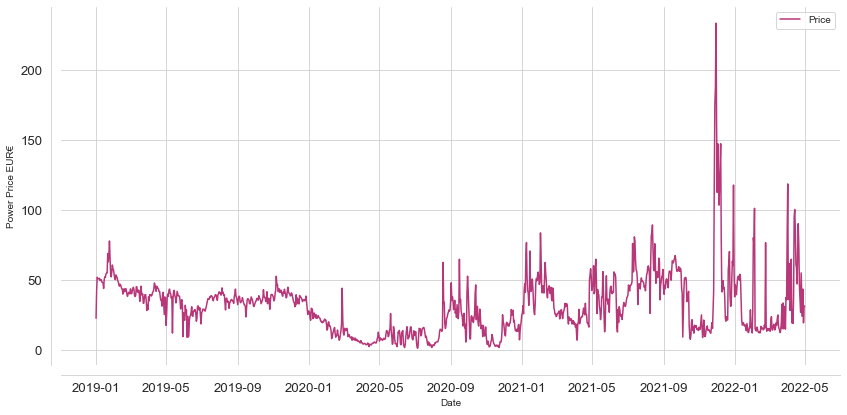

In [30]:
sns.set_style('whitegrid') 
fig=plt.figure(figsize=(12,6))
sns.lineplot(data=P,palette='magma',linewidth=1.5)
plt.ylabel('Power Price EUR€')
sns.set_context('paper', font_scale=1.5, rc={'lines.linewidth':1.5})
sns.despine(offset=(10,10),trim=False)
plt.tight_layout()

In [31]:
# sns.set_style('ticks') 
# fig=plt.figure(figsize=(12,6))
# sns.lineplot(data=windspeed,palette='summer',linewidth=1.5)
# plt.ylabel('kph')
# sns.set_context('paper', font_scale=1.5, rc={'lines.linewidth':1.5})
# sns.despine(offset=(10,10),trim=False)
# plt.tight_layout()

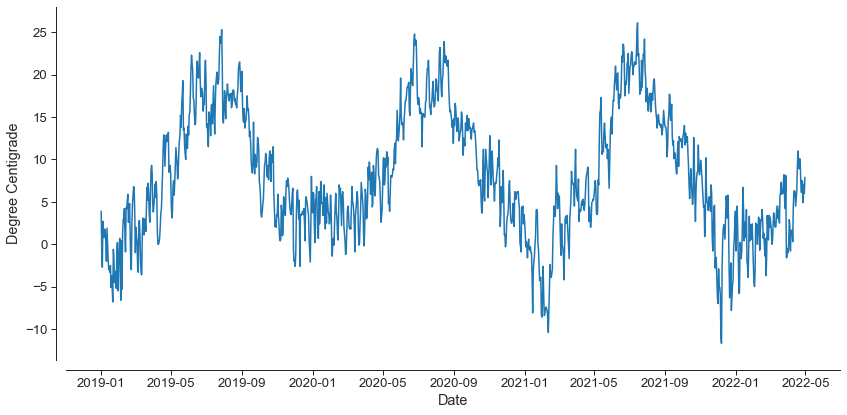

In [32]:
sns.set_style('ticks') 
fig=plt.figure(figsize=(12,6))
sns.lineplot(data=W.temp,palette='winter',linewidth=1.5)
plt.ylabel('Degree Centigrade')
sns.set_context('paper', font_scale=1.5, rc={'lines.linewidth':1.5})
sns.despine(offset=(10,10),trim=False)
plt.tight_layout()

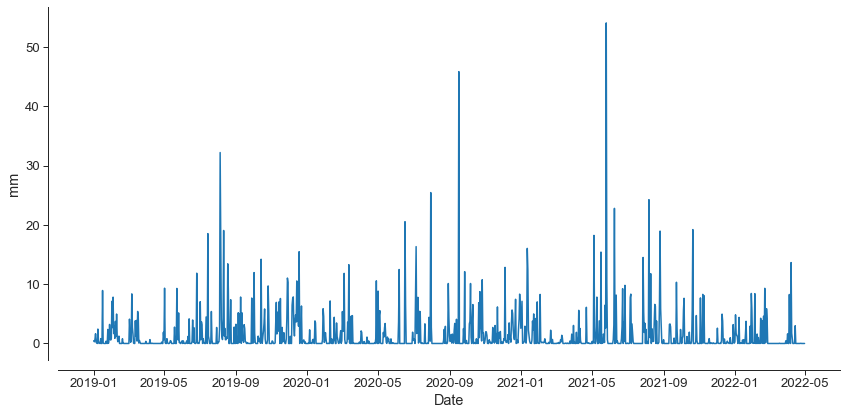

In [33]:
sns.set_style('ticks') 
fig=plt.figure(figsize=(12,6))
sns.lineplot(data=W.precip,palette='viridis',linewidth=1.5)
plt.ylabel('mm')
sns.set_context('paper', font_scale=1.5, rc={'lines.linewidth':1.5})
sns.despine(offset=(10,10),trim=False)
plt.tight_layout()

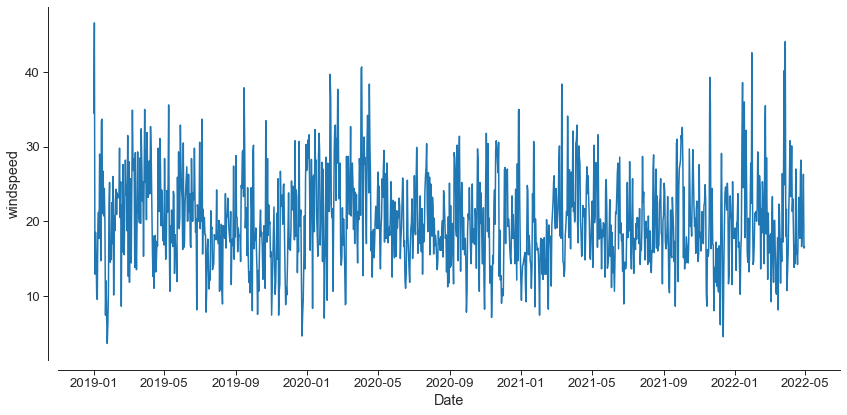

In [34]:
sns.set_style('ticks') 
fig=plt.figure(figsize=(12,6))
sns.lineplot(data=W.windspeed,palette='summer',linewidth=1.5)
# plt.ylabel('Power Price EUR€')
sns.set_context('paper', font_scale=1.5, rc={'lines.linewidth':1.5})
sns.despine(offset=(10,10),trim=False)
plt.tight_layout()

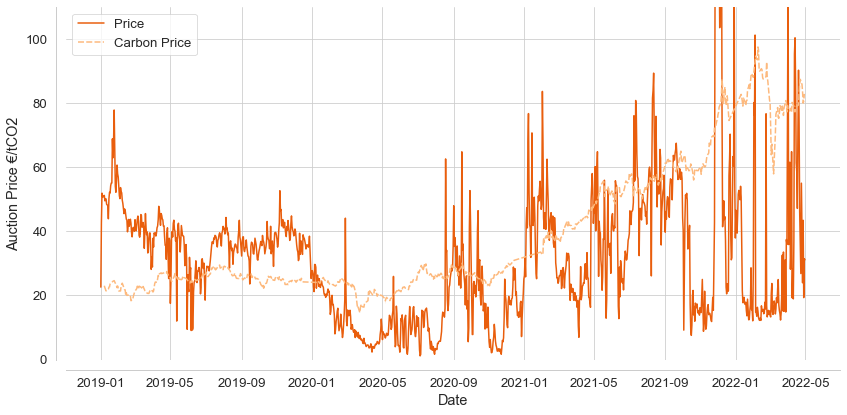

In [99]:
sns.set_style('whitegrid') 
fig=plt.figure(figsize=(12,6))
sns.lineplot(data=C,palette='Oranges_r',linewidth=1.5)
plt.ylim(0,110)
plt.ylabel('Auction Price €/tCO2')
sns.set_context('paper', font_scale=1.5, rc={'lines.linewidth':1.5})
sns.despine(offset=(10,10),trim=False)
plt.tight_layout()

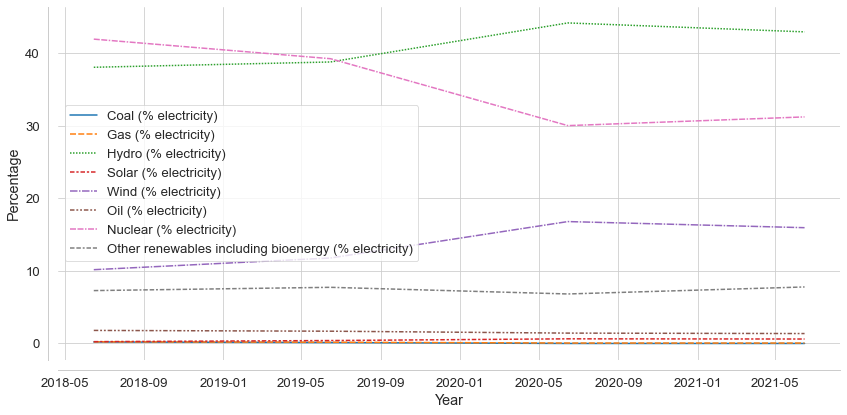

In [36]:
sns.set_style('whitegrid') 
fig=plt.figure(figsize=(12,6))
sns.lineplot(data=S,linewidth=1.5)
plt.ylabel('Percentage')
# sns.set_context('paper', font_scale=1.5, rc={'lines.linewidth':1.5})
sns.despine(offset=(10,10),trim=False)
plt.tight_layout()

<AxesSubplot:ylabel='Price'>

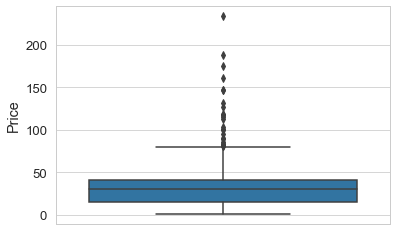

In [37]:
sns.boxplot(y=table['Price'])

<AxesSubplot:ylabel='temp'>

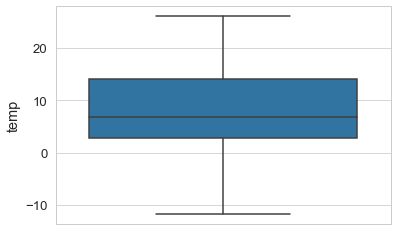

In [38]:
sns.boxplot(y=table['temp'])

<AxesSubplot:ylabel='precip'>

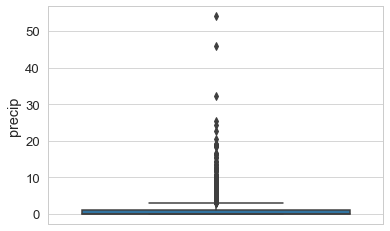

In [39]:
sns.boxplot(y=table['precip'])

<AxesSubplot:ylabel='windspeed'>

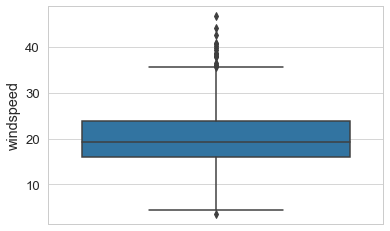

In [40]:
sns.boxplot(y=table['windspeed'])

<AxesSubplot:ylabel='Carbon Price'>

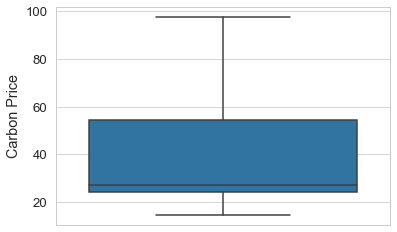

In [41]:
sns.boxplot(y=C['Carbon Price'])

temp

In [42]:
np.cov(Price, W.temp)

array([[456.31274357, -27.75391367],
       [-27.75391367,  54.55891445]])

In [43]:
corr1, _ = pearsonr(Price, temp)
print("pearsonr correlation is", corr1)

pearsonr correlation is [-0.17589766482153818]


In [44]:
corr2, _ = spearmanr(Price, temp)
print("spearmanr correlation", corr2)

spearmanr correlation -0.12984467168972372


precip

In [45]:
np.cov(Price,W.precip)

array([[4.56312744e+02, 2.73541393e-01],
       [2.73541393e-01, 1.41891451e+01]])

In [46]:
corr1, _ = pearsonr(Price,precip)
print("pearsonr correlation is", corr1)

pearsonr correlation is [0.003399489006799467]


In [47]:
corr2, _ = spearmanr(Price,precip)
print("spearmanr correlation", corr2)

spearmanr correlation 0.022456290762583642


wind

In [48]:
np.cov(Price,W.windspeed)

array([[456.31274357, -35.90053149],
       [-35.90053149,  38.35187998]])

In [49]:
corr1, _ = pearsonr(Price,windspeed)
print("pearsonr correlation is", corr1)

pearsonr correlation is [-0.27137900796144093]


In [50]:
corr2, _ = spearmanr(Price,windspeed)
print("spearmanr correlation", corr2)

spearmanr correlation -0.2624702531860014


Text(0.5, 0, 'Power Price €/tCO2')

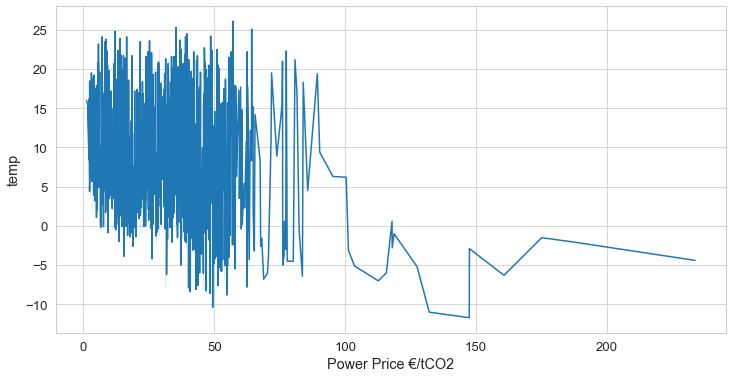

In [51]:

fig=plt.figure(figsize=(12,6))
sns.lineplot(x=Price,y=W.temp,palette='bone',linewidth=1.5,)
plt.xlabel('Power Price €/tCO2')
# plt.ylabel('Auction Price €/tCO2')
# sns.set_context('paper', font_scale=1.5, rc={'lines.linewidth':1.5})
# sns.despine(offset=(10,10),trim=False)

Text(0.5, 0, 'Power Price €/tCO2')

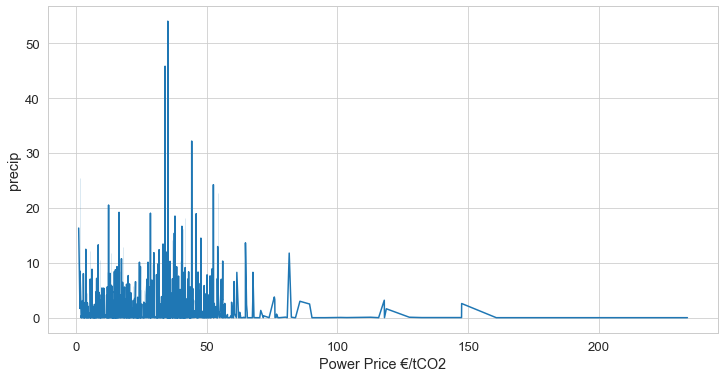

In [52]:
fig=plt.figure(figsize=(12,6))
sns.lineplot(x=Price,y=W.precip,palette='tab10',linewidth=1.5,)
plt.xlabel('Power Price €/tCO2')

Text(0.5, 0, 'Power Price €/tCO2')

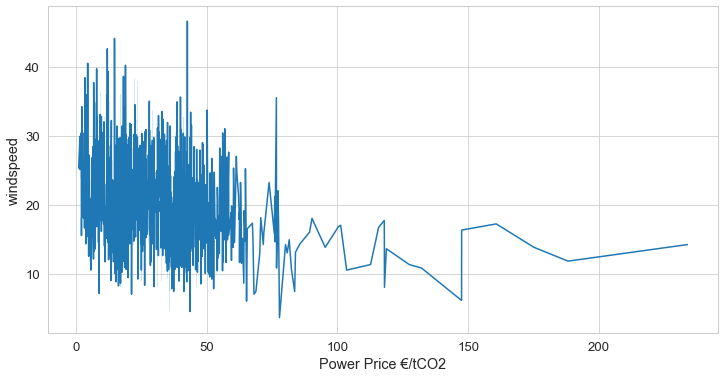

In [53]:
fig=plt.figure(figsize=(12,6))
sns.lineplot(x=Price,y=W.windspeed,palette='tab10',linewidth=1.5,)
plt.xlabel('Power Price €/tCO2')

<AxesSubplot:xlabel='Price', ylabel='temp'>

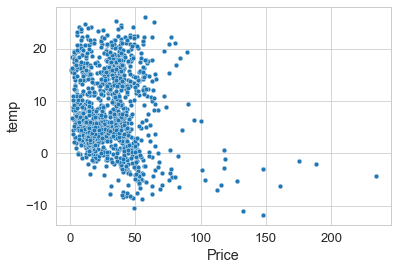

In [54]:
sns.scatterplot(data=table,x=Price,y=W.temp)

<AxesSubplot:xlabel='Price', ylabel='precip'>

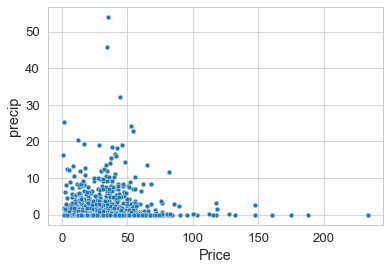

In [55]:
sns.scatterplot(data=table,x=Price,y=W.precip)

<AxesSubplot:xlabel='Price', ylabel='windspeed'>

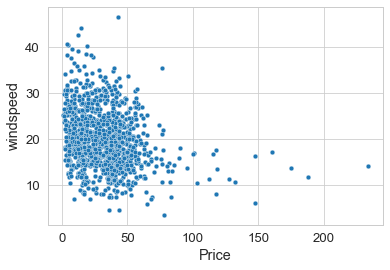

In [56]:
sns.scatterplot(data=table,x=Price,y=W.windspeed)

In [57]:
table.head()

,Date,Price,temp,precip,windspeed
Date,,,,,
2019-01-01,2019-01-01,22.58,3.9,0.46,34.5
2019-01-02,2019-01-02,42.65,-1.1,0.29,46.6
2019-01-03,2019-01-03,51.90,-2.7,0.69,12.9
2019-01-04,2019-01-04,50.85,2.7,1.64,18.5
2019-01-05,2019-01-05,50.72,0.8,0.17,15.6


In [58]:
P

,Date,Price
Date,,
2019-01-01,2019-01-01,22.58
2019-01-02,2019-01-02,42.65
2019-01-03,2019-01-03,51.90
2019-01-04,2019-01-04,50.85
2019-01-05,2019-01-05,50.72
...,...,...
2022-04-26,2022-04-26,23.94
2022-04-27,2022-04-27,43.43
2022-04-28,2022-04-28,19.30


In [59]:
W

,Date,temp,precip,windspeed
Date,,,,
2019-01-01,2019-01-01,3.9,0.46,34.5
2019-01-02,2019-01-02,-1.1,0.29,46.6
2019-01-03,2019-01-03,-2.7,0.69,12.9
2019-01-04,2019-01-04,2.7,1.64,18.5
2019-01-05,2019-01-05,0.8,0.17,15.6
...,...,...,...,...
2022-04-26,2022-04-26,7.3,0.00,19.0
2022-04-27,2022-04-27,4.9,0.00,20.2
2022-04-28,2022-04-28,7.0,0.00,26.3


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     38.76
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           6.59e-10
Time:                        02:21:55   Log-Likelihood:                -5428.7
No. Observations:                1216   AIC:                         1.086e+04
Df Residuals:                    1214   BIC:                         1.087e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.6823      0.894     39.902      0.0

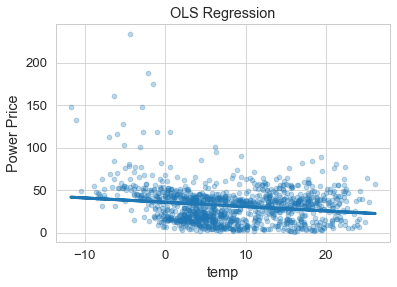

In [60]:
x=W['temp']
Y=Price
X = sm.add_constant(x)
model = sm.OLS(Y,X)
results = model.fit()
plt.scatter(x,Y,alpha=0.3)
y_predict = results.params[0] + results.params[1]*x
plt.plot(x,y_predict, linewidth=3)
plt.xlabel('temp')
plt.ylabel('Power Price')
plt.title('OLS Regression')
print(results.summary())

### Offset Self

In [61]:
Df=pd.concat([P,W.loc[:,W.columns!='Date']],axis=1)
df=Df.copy()

In [62]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
    linewidth=1.5
)

In [63]:
X = df.loc[:, ['temp','precip','windspeed']]  # features
x_train=X.loc['2019-01-01':'2022-01-31',:]
x_test=X.loc['2022-02-01':'2022-04-30',:]
y = df.loc[:, ['Price']]  # target
y_train=y.loc['2019-01-01':'2022-01-31',:]
y_test=y.loc['2022-02-01':'2022-04-30',:]

In [64]:
# Pre-process data
scaler = MinMaxScaler() 
x_train1 = scaler.fit_transform(x_train)
x_test1 = scaler.transform(x_test)
scaler = StandardScaler()
x_train2 = scaler.fit_transform(x_train)
x_test2 = scaler.transform(x_test)

time dummy

In [65]:
df['Time'] = np.arange(len(df.index))

In [66]:
# Train the model
model = LinearRegression()
model.fit(x_train1, y_train)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(x_test1).T[0], index=x_test.index)

In [67]:
print('MSE:',mean_squared_error(y_test,y_pred),'\nr2_score:', r2_score(y_test,y_pred))

MSE: 642.9155721147512 
r2_score: 0.019505959903937775


Text(0.5, 1.0, 'Time Plot of Tunnel Traffic')

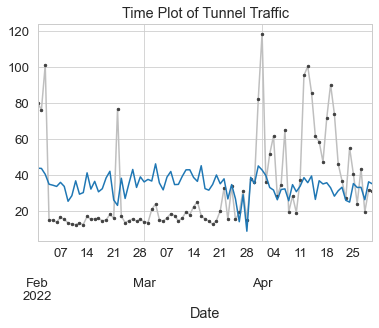

In [68]:
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=1.5)
ax.set_title('Time Plot of Tunnel Traffic')

In [69]:
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'Price']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

Lag features

In [70]:
df['Lag_1'] = df['Price'].shift(1)
df = df.reindex(columns=['Price', 'Lag_1'])

In [71]:
# fig, ax = plt.subplots()
# ax = sns.regplot(x='Lag_1', y='Price', data=df, ci=None, scatter_kws=dict(color='0.25'))
# ax.set_aspect('equal')
# ax.set_title('Lag Plot of Power Price')

In [72]:
X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, ['Price']]  # create the target
y, X = y.align(X, join='inner',axis=0)  # drop corresponding values in target

In [73]:
x_train=X.loc['2019-01-02':'2022-01-31',:]
x_test=X.loc['2022-02-01':'2022-04-30',:]
y_train=y.loc['2019-01-02':'2022-01-31',:]
y_test=y.loc['2022-02-01':'2022-04-30',:]

In [74]:
model = LinearRegression()
model.fit(x_train, y_train)

y_pred = pd.Series(model.predict(x_test).T[0], index=x_test.index)

In [75]:
print('MSE:',mean_squared_error(y_test,y_pred),'\nr2_score:', r2_score(y_test,y_pred))

MSE: 463.7243282696216 
r2_score: 0.29278592736472053


Text(0.5, 1.0, 'Lag Plot of Power Price')

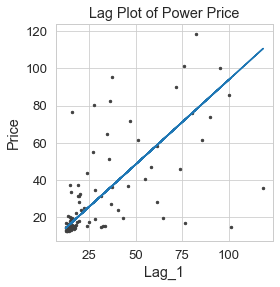

In [76]:
fig, ax = plt.subplots()
ax.plot(x_test['Lag_1'], y_test, '.', color='0.25')
ax.plot(x_test['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('Price')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Power Price')

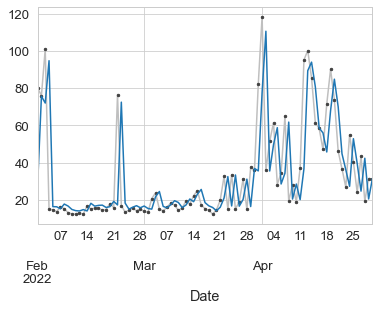

In [77]:
ax = y_test.plot(**plot_params)
ax = y_pred.plot()

In [78]:
com=pd.concat([y_pred,y_test],axis=1)

In [79]:
com.columns=['Pred','Ture']

In [80]:
com

,Pred,Ture
Date,,
2022-02-01,28.003907,80.15
2022-02-02,75.736144,76.12
2022-02-03,72.072127,101.22
2022-02-04,94.892682,14.76
2022-02-05,16.284506,14.68
...,...,...
2022-04-26,39.477828,23.94
2022-04-27,24.630829,43.43
2022-04-28,42.350854,19.30


### Offset with elements

In [81]:
df=Df.copy()

In [82]:
df

,Date,Price,temp,precip,windspeed
Date,,,,,
2019-01-01,2019-01-01,22.58,3.9,0.46,34.5
2019-01-02,2019-01-02,42.65,-1.1,0.29,46.6
2019-01-03,2019-01-03,51.90,-2.7,0.69,12.9
2019-01-04,2019-01-04,50.85,2.7,1.64,18.5
2019-01-05,2019-01-05,50.72,0.8,0.17,15.6
...,...,...,...,...,...
2022-04-26,2022-04-26,23.94,7.3,0.00,19.0
2022-04-27,2022-04-27,43.43,4.9,0.00,20.2
2022-04-28,2022-04-28,19.30,7.0,0.00,26.3


In [96]:
df['Lag_temp'] = Df['temp'].shift(1)
df = df.reindex(columns=['Price','Lag_temp'])
X = df.loc[:, ['Lag_temp']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, ['Price']]  # create the target
y, X = y.align(X, join='inner',axis=0)  # drop corresponding values in target

Text(0.5, 1.0, 'Lag Plot of Power Price')

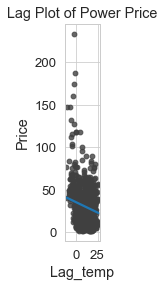

In [97]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_temp', y='Price', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Power Price')

In [92]:
X = df.loc[:, ['Lag_temp']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, ['Price']]  # create the target
y, X = y.align(X, join='inner',axis=0)  # drop corresponding values in target

In [93]:
x_train=X.loc['2019-01-02':'2022-01-31',:]
x_test=X.loc['2022-02-01':'2022-04-30',:]
y_train=y.loc['2019-01-02':'2022-01-31',:]
y_test=y.loc['2022-02-01':'2022-04-30',:]

In [94]:
model = LinearRegression()
model.fit(x_train, y_train)

y_pred = pd.Series(model.predict(x_test).T[0], index=x_test.index)

In [95]:
print('MSE:',mean_squared_error(y_test,y_pred),'\nr2_score:', r2_score(y_test,y_pred))

MSE: 656.9771359957122 
r2_score: -0.0019389703135115344


KeyError: 'Lag_1'

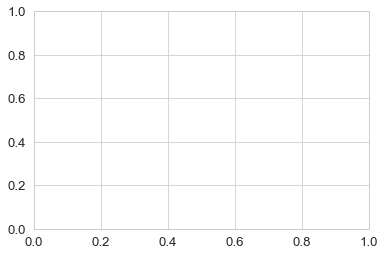

In [89]:
fig, ax = plt.subplots()
ax.plot(x_test['Lag_1'], y_test, '.', color='0.25')
ax.plot(x_test['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('Price')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Power Price')

In [ ]:
ax = y_test.plot(**plot_params)
ax = y_pred.plot()

In [ ]:
com=pd.concat([y_pred,y_test],axis=1)

In [ ]:
com.columns=['Pred','Ture']

In [ ]:
com